# Distribuições de Probabilidade e Amostragem

## Probabilidade de alguém ser usuário de uma operadora de telefonia

Qual é a probabilidade de uma pessoa no Brasil ser cliente da VIVO, CLARO ou TIM?

Fonte: https://sistemas.anatel.gov.br/anexar-api/publico/anexos/download/44aaef993685036f18cab2ea0b4561e2

Sendo que o percentual do mercado já foi calculado, iremos apenas normalizar o percentual para somar 1.

Se considerarmos a população do país de 213.421.037 habitantes (https://www.ibge.gov.br/), podemos multiplicar a probabilidade pela quantidade total de habitantes e inferir a quantidade de usuários de determinada operadora.

In [8]:
import pandas as pd

# Caminho do arquivo CSV
csv_path = 'Aula2/julio/Operadoradetelefonia-Pctmercado-Perodo.csv'

# Lê o CSV em um DataFrame
df = pd.read_csv(csv_path)

# Adiciona a coluna "P" como probabilidade (percentual dividido por 100)
df['P'] = df['Pct mercado'] / 100

# Exibe o DataFrame resultante
# print(df)

# Filtra apenas pelo período "2T2025"
filtered_df = df[df['Período'] == '2T2025']
print(filtered_df)

# Some todas as probabilidades de filtered_df
total_probability = filtered_df['P'].sum()
print(f'Probabilidade total deve somar 1: {total_probability}')

# Salve o DataFrame filtrado em um novo CSV
filtered_csv_path = 'Aula2/julio/Operadoradetelefonia-Pctmercado-2T2025.csv'
filtered_df.to_csv(filtered_csv_path, index=False)

   Operadora de telefonia  Pct mercado Período       P
1                    VIVO        38.50  2T2025  0.3850
3                   CLARO        32.52  2T2025  0.3252
5                     TIM        23.40  2T2025  0.2340
7                   ALGAR         1.68  2T2025  0.0168
9                  Datora         1.13  2T2025  0.0113
11                   SURF         0.93  2T2025  0.0093
13             Next Level         0.42  2T2025  0.0042
15              Teleports         0.32  2T2025  0.0032
17               BRISANET         0.09  2T2025  0.0009
19                   VERO         0.08  2T2025  0.0008
21               UNIFIQUE         0.06  2T2025  0.0006
23                  LIGGA         0.01  2T2025  0.0001
Probabilidade total deve somar 1: 0.9914000000000002


In [12]:
# Lê o CSV filtrado em um novo DataFrame
df = pd.read_csv(filtered_csv_path)

# crie uma nova coluna "Estimated Users" que multiplica a probabilidade "P" pela população total do Brasil (213421037)
population_brazil = 213421037
df['Estimated Users'] = df['P'] * population_brazil
print(df)
print('+82 bilhões de usuários da VIVO no Brasil')

   Operadora de telefonia  Pct mercado Período       P  Estimated Users
0                    VIVO        38.50  2T2025  0.3850     8.216710e+07
1                   CLARO        32.52  2T2025  0.3252     6.940452e+07
2                     TIM        23.40  2T2025  0.2340     4.994052e+07
3                   ALGAR         1.68  2T2025  0.0168     3.585473e+06
4                  Datora         1.13  2T2025  0.0113     2.411658e+06
5                    SURF         0.93  2T2025  0.0093     1.984816e+06
6              Next Level         0.42  2T2025  0.0042     8.963684e+05
7               Teleports         0.32  2T2025  0.0032     6.829473e+05
8                BRISANET         0.09  2T2025  0.0009     1.920789e+05
9                    VERO         0.08  2T2025  0.0008     1.707368e+05
10               UNIFIQUE         0.06  2T2025  0.0006     1.280526e+05
11                  LIGGA         0.01  2T2025  0.0001     2.134210e+04
+82 bilhões de usuários da VIVO no Brasil



No SGBD clickhouse, criar um DB IBGE

https://clickhouse.com/docs/knowledgebase/importing-geojason-with-nested-object-array#question
https://sidra.ibge.gov.br/home/pnadct/brasil
https://www.ibge.gov.br/geociencias/organizacao-do-territorio/estrutura-territorial/26565-malhas-de-setores-censitarios-divisoes-intramunicipais.html


- carregar shape (geojson)
- fazer operações geoespacias
- fazer JOIN e mostrar distribuições

### Descomprimir e mover para a pasta de leitura do clickhouse

```bash
cd /workspaces/Stats-In-Codespace/Aula2/julio
unzip BR_Municipios_2024.geojson.zip
sudo mv BR_Municipios_2024.geojson /var/lib/clickhouse/user_files
```

Depois de entrar no clickhouse-client:

```sql
DESCRIBE TABLE file('BR_Municipios_2024.geojson', 'JSON')
```

Vemos:
```bash
DESCRIBE TABLE file('BR_Municipios_2024.geojson', 'JSON')

Query id: 69b90589-8b43-4dbf-b461-b98de6c61636

Row 1:
──────
name:               type
type:               Nullable(String)
default_type:       
default_expression: 
comment:            
codec_expression:   
ttl_expression:     

Row 2:
──────
name:               name
type:               Nullable(String)
default_type:       
default_expression: 
comment:            
codec_expression:   
ttl_expression:     

Row 3:
──────
name:               features
type:               Array(Tuple(
    geometry Tuple(
        coordinates Array(Array(Array(Array(Nullable(Float64))))),
        type Nullable(String)),
    properties Tuple(
        AREA_KM2 Nullable(Float64),
        CD_CONCU Nullable(String),
        CD_MUN Nullable(String),
        CD_REGIA Nullable(String),
        CD_RGI Nullable(String),
        CD_RGINT Nullable(String),
        CD_UF Nullable(String),
        NM_CONCU Nullable(String),
        NM_MUN Nullable(String),
        NM_REGIA Nullable(String),
        NM_RGI Nullable(String),
        NM_RGINT Nullable(String),
        NM_UF Nullable(String),
        SIGLA_RG Nullable(String),
        SIGLA_UF Nullable(String)),
    type Nullable(String)))
default_type:       
default_expression: 
comment:            
codec_expression:   
ttl_expression:     

3 rows in set. Elapsed: 9.143 sec. 
```

Criar a tabela:

```sql
create database ibge;
use ibge;
CREATE TABLE br_municipios
(
    type String,
    name String,
    featureType String,
    
    -- Dados do município
    cd_mun String,
    nm_mun String,
    area_km2 Float64,
    
    -- Dados da UF
    cd_uf String,
    nm_uf String,
    sigla_uf String,
    
    -- Dados regionais
    cd_concu Nullable(String),
    nm_concu Nullable(String),
    cd_regia Nullable(String),
    nm_regia Nullable(String),
    cd_rgi Nullable(String),
    nm_rgi Nullable(String),
    cd_rgint Nullable(String),
    nm_rgint Nullable(String),
    sigla_rg Nullable(String),
    
    -- Geometria
    geometryType String,
    geometry MultiPolygon
)
ENGINE = MergeTree
ORDER BY (cd_uf, cd_mun);
```

Verificando antes de inserir.

```sql
SELECT
    type,
    name,
    features.type AS featureType,
    features.properties.CD_MUN AS cd_mun,
    features.properties.NM_MUN AS nm_mun,
    features.properties.SIGLA_UF AS sigla_uf,
    features.geometry.type AS geometryType
FROM file('BR_Municipios_2024.geojson', 'JSON')
ARRAY JOIN features
LIMIT 5;
```

Inserindo os dados:
```sql
INSERT INTO br_municipios
SELECT
    type,
    name,
    features.type AS featureType,
    
    -- Dados do município
    features.properties.CD_MUN AS cd_mun,
    features.properties.NM_MUN AS nm_mun,
    features.properties.AREA_KM2 AS area_km2,
    
    -- Dados da UF
    features.properties.CD_UF AS cd_uf,
    features.properties.NM_UF AS nm_uf,
    features.properties.SIGLA_UF AS sigla_uf,
    
    -- Dados regionais
    features.properties.CD_CONCU AS cd_concu,
    features.properties.NM_CONCU AS nm_concu,
    features.properties.CD_REGIA AS cd_regia,
    features.properties.NM_REGIA AS nm_regia,
    features.properties.CD_RGI AS cd_rgi,
    features.properties.NM_RGI AS nm_rgi,
    features.properties.CD_RGINT AS cd_rgint,
    features.properties.NM_RGINT AS nm_rgint,
    features.properties.SIGLA_RG AS sigla_rg,
    
    -- Geometria
    features.geometry.type AS geometryType,
    arrayMap(
        poly -> arrayMap(
            ring -> arrayMap(
                coord -> (coord[1], coord[2]),
                ring
            ),
            poly
        ),
        features.geometry.coordinates
    ) AS geometry
FROM file('BR_Municipios_2024.geojson', 'JSON')
ARRAY JOIN features;
```

Verificar:

```sql
-- Contar registros
SELECT count(*) FROM br_municipios;

-- Verificar o tipo da geometria
SELECT DISTINCT toTypeName(geometry) FROM br_municipios;

-- Ver alguns municípios por estado
SELECT sigla_uf, count(*) AS total_municipios
FROM br_municipios
GROUP BY sigla_uf
ORDER BY sigla_uf;
```

### calculando o centroide de cada polígono

```sql
-- Função auxiliar para calcular área usando a fórmula shoelace
CREATE FUNCTION area AS (v1, v2) -> 
    ((v1.1 * v2.2) - (v2.1 * v1.2));

-- Função para calcular a área assinada do polígono
CREATE FUNCTION signed_area AS polygon ->
    arrayFold(
        (acc, x) -> (
            (acc.1) + ((((x.1).1) + ((polygon[((x.2) + 1) % (length(polygon) + 1)]).1)) 
                * area(x.1, polygon[((x.2) + 1) % (length(polygon) + 1)])),
            (acc.2) + ((((x.1).2) + ((polygon[((x.2) + 1) % (length(polygon) + 1)]).2)) 
                * area(x.1, polygon[((x.2) + 1) % (length(polygon) + 1)])),
            (acc.3) + area(x.1, polygon[((x.2) + 1) % (length(polygon) + 1)])
        ),
        arrayZip(polygon, range(1, length(polygon) + 1)),
        (0.0, 0.0, 0.0)
    );

-- Função principal para calcular o centroide
CREATE FUNCTION centroid AS polygon -> (
    (signed_area(polygon).1) / ((6 * (signed_area(polygon).3)) * 0.5),
    (signed_area(polygon).2) / ((6 * (signed_area(polygon).3)) * 0.5)
);
```

### Calcular Centroides para Cada Município

Opção 1: Adicionar Colunas à Tabela Existente
```sql
-- Adicionar colunas para longitude e latitude do centroide
ALTER TABLE br_municipios 
    ADD COLUMN centroid_lon Float64,
    ADD COLUMN centroid_lat Float64;

-- Calcular e atualizar os centroides
-- Nota: Para MultiPolygon, usamos o primeiro polígono (principal)
ALTER TABLE br_municipios 
UPDATE 
    centroid_lon = centroid(geometry[1][1]).1,
    centroid_lat = centroid(geometry[1][1]).2
WHERE 1=1;
```
Opção 2: Consulta Direta
```sql
SELECT 
    cd_mun,
    nm_mun,
    sigla_uf,
    
    -- Centroide do primeiro polígono (principal)
    centroid(geometry[1][1]).1 AS centroid_lon,
    centroid(geometry[1][1]).2 AS centroid_lat,
    
    -- Ou como tupla (Point)
    centroid(geometry[1][1]) AS centroid_point,
    
    area_km2
FROM br_municipios
ORDER BY sigla_uf, nm_mun
LIMIT 10;
```
Verificar os Resultados
```sql
-- Ver alguns exemplos
SELECT 
    nm_mun,
    sigla_uf,
    round(centroid_lon, 6) AS longitude,
    round(centroid_lat, 6) AS latitude
FROM br_municipios
WHERE sigla_uf = 'RJ'
ORDER BY nm_mun
LIMIT 5;
```
Criar Vista com Centroides
```sql
CREATE VIEW municipios_com_centroides AS
SELECT 
    *,
    centroid(geometry[1][1]).1 AS centroid_lon,
    centroid(geometry[1][1]).2 AS centroid_lat
FROM br_municipios;
```


Carregando um arquivo CSV

## População por municipio em 2025 - fonte https://sidra.ibge.gov.br/tabela/6579

tabela6579.CSV

file -i tabela6579.csv 
tabela6579.csv: text/plain; charset=iso-8859-1

Converte para UTF8

iconv -f iso-8859-1 -t utf8 tabela6579.csv > tabela6579utf8.csv

Criar tabela no DB
```sql
Use ibge;
CREATE TABLE IF NOT EXISTS municipio6579
(
    codigo String,
    municipio String,
    populacao UInt32
)
ENGINE = MergeTree()
ORDER BY codigo;
```

### Remover o cabeçalho e importar

```bash
clickhouse-client --query="INSERT INTO ibge.municipio6579 FORMAT CSV" --format_csv_delimiter=";" --input_format_skip_unknown_fields=1 < <(tail -n +2 tabela6579utf8.csv)
```

Agora podemos fazer um JOIN das tabelas e descobrir a população por município.

```sql
select
  mm.area_km2, m.populacao
from
  br_municipios mm inner join municipio6579 m
  on mm.cd_mun = m.codigo;
```


## Tabela 8114 - Pessoas de 15 anos ou mais de idade, ocupadas na semana de referência, que se deslocava da casa para o trabalho, por tempo de deslocamento por dia e situação do domicílio - https://sidra.ibge.gov.br/Tabela/8114

## Tabela 10333 - Pessoas de 10 anos ou mais de idade, ocupadas na semana de referência, que, no trabalho principal, trabalhavam fora do domicílio, por tempo habitual de deslocamento do domicílio para o trabalho principal, nível de instrução, grupo de idade e cor ou raça - https://sidra.ibge.gov.br/Tabela/10333

Tabela 10333 - Pessoas de 10 anos ou mais de idade, ocupadas na semana de referência, que, no trabalho principal, trabalhavam fora do domicílio, por tempo habitual de deslocamento do domicílio para o trabalho principal, nível de instrução, grupo de idade e cor ou raça								
Cor ou raça - Total								
Nível de instrução - Total								
Grupo de idade - Total								
Ano - 2022								
Variável - Pessoas de 10 anos ou mais de idade, ocupadas na semana de referência, que, no trabalho principal, trabalhavam fora do domicílio (Pessoas)								

*Tempo habitual de deslocamento do domicílio para o trabalho principal*

```sql
Use ibge;
CREATE TABLE IF NOT EXISTS casatrabalho10333
(
    codigo String,
    municipio String,
    ate5min UInt32,
    d6ate15m UInt32,
    d15ate30m UInt32,
    d30mate1h UInt32,
    d1ate2h UInt32,
    d2ate4h UInt32,
    m4h UInt32
)
ENGINE = MergeTree()
ORDER BY codigo;
```

O arquivo do IBGE possui "-" no lugar de valores nulos. Para carregar no banco de dados precisamos substituir os "-" por "0" (zero), mas apenas quando o traço for precedido de ";".

```bash
sed 's/;-/;0/g' tabela10333utf8.csv > tabela10333utf8v2.csv
```

Removi a última linha manualmente, que possui um texto descritivo.

### Remover o cabeçalho e importar

```bash
clickhouse-client --query="INSERT INTO ibge.casatrabalho10333 FORMAT CSV" --format_csv_delimiter=";" --input_format_skip_unknown_fields=1 < <(tail -n +2 tabela10333utf8v2.csv)
```

### Podemos montar algumas distribuições

#### qtd de pessoas vs qtd de horas até o trabalho


```sql
SELECT
    m.populacao,
    ct.ate5min
FROM municipio6579 m inner join casatrabalho10333 ct on ct.codigo = m.codigo
ORDER BY m.populacao
LIMIT 30;
```


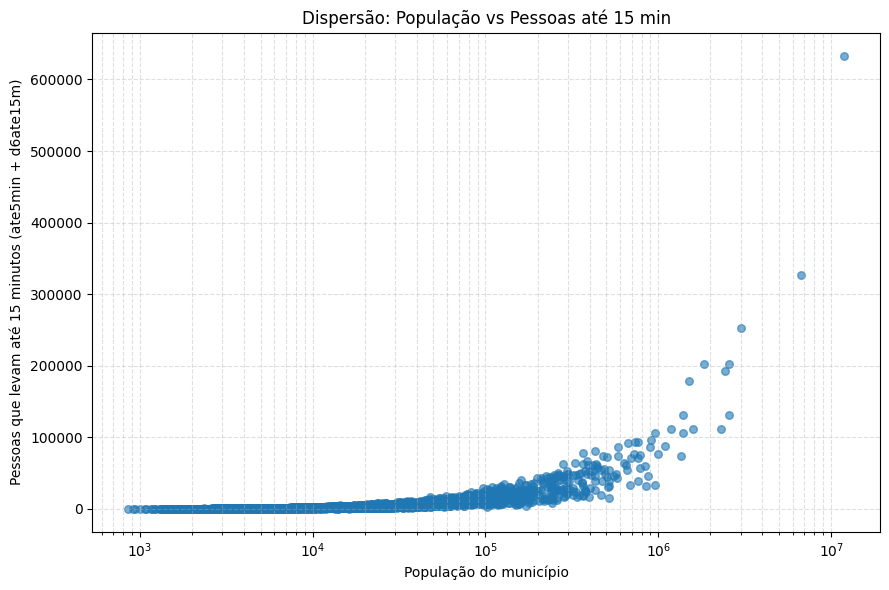

In [ ]:
# Quantidade de pessoas que chegam em até 15 minutos ao trabalho vs população do município
# testar com clickhouse_connect
from clickhouse_driver import Client
import pandas as pd
import matplotlib.pyplot as plt

# Configurar conexão com ClickHouse (ajuste host, user, password conforme seu ambiente)
client = Client(host='localhost', user='default', password='785498')

# Query SQL
query = """
SELECT
    m.populacao,
    ct.ate5min,
    ct.d6ate15m
FROM ibge.municipio6579 m
INNER JOIN ibge.casatrabalho10333 ct ON ct.codigo = m.codigo
ORDER BY m.populacao
"""

rows, columns_info = client.execute(
    query,
    with_column_types=True,
    columnar=False   # <--- isso elimina completamente a necessidade do extra NumPy
)

column_names = [col[0] for col in columns_info]

df_q = pd.DataFrame(rows, columns=column_names)

# Garantir colunas numéricas e computar "até 15 min" (até 5 + 6-15)
df_q['populacao'] = pd.to_numeric(df_q['populacao'], errors='coerce')
df_q['ate5min'] = pd.to_numeric(df_q.get('ate5min', 0), errors='coerce').fillna(0)
df_q['d6ate15m'] = pd.to_numeric(df_q.get('d6ate15m', 0), errors='coerce').fillna(0)
df_q['ate_ate15min'] = df_q['ate5min'] + df_q['d6ate15m']
df_q = df_q.dropna(subset=['populacao', 'ate_ate15min'])

# Plot
plt.figure(figsize=(9,6))
plt.scatter(df_q['populacao'], df_q['ate_ate15min'], alpha=0.6, s=30)
plt.xscale('log')  # opcional: melhora visualização quando há muitos municípios pequenos
plt.xlabel('População do município')
plt.ylabel('Pessoas que levam até 15 minutos (ate5min + d6ate15m)')
plt.title('Dispersão: População vs Pessoas até 15 min')
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.tight_layout()
plt.show()

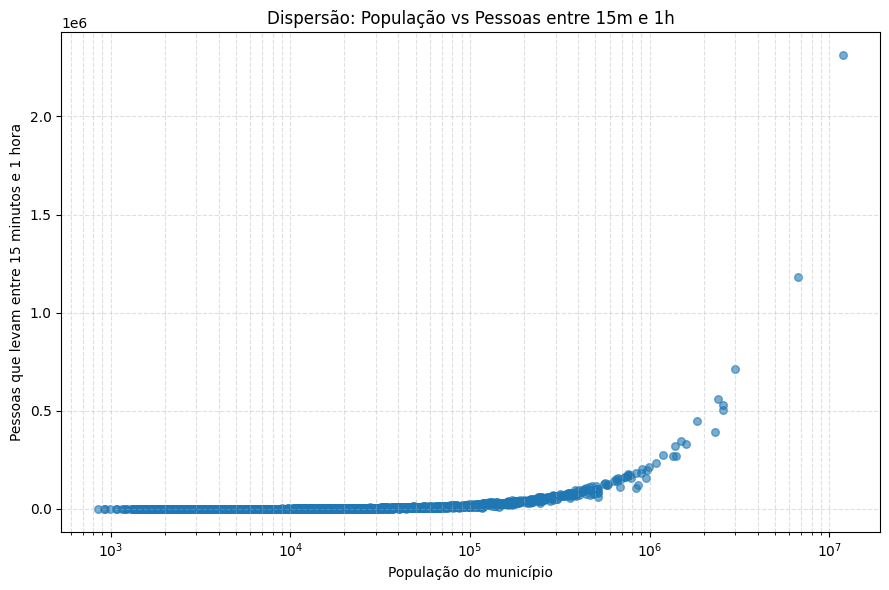

In [5]:
# Quantidade de pessoas que chegam no trabalho entre 15 minutos e 1 hora vs população do município

from clickhouse_driver import Client
import pandas as pd
import matplotlib.pyplot as plt

# Configurar conexão com ClickHouse (ajuste host, user, password conforme seu ambiente)
client = Client(host='localhost', user='default', password='785498')

# Query SQL
query = """
SELECT
    m.populacao,
    ct.d15ate30m,
    ct.d30mate1h
FROM ibge.municipio6579 m
INNER JOIN ibge.casatrabalho10333 ct ON ct.codigo = m.codigo
ORDER BY m.populacao
"""

rows, columns_info = client.execute(
    query,
    with_column_types=True,
    columnar=False
)

column_names = [col[0] for col in columns_info]

df_q = pd.DataFrame(rows, columns=column_names)

# Garantir colunas numéricas e computar (entre 15m e 1h)
df_q['populacao'] = pd.to_numeric(df_q['populacao'], errors='coerce')
df_q['d15ate30m'] = pd.to_numeric(df_q.get('d15ate30m', 0), errors='coerce').fillna(0)
df_q['d30mate1h'] = pd.to_numeric(df_q.get('d30mate1h', 0), errors='coerce').fillna(0)
df_q['entre15me1h'] = df_q['d15ate30m'] + df_q['d30mate1h']
df_q = df_q.dropna(subset=['populacao', 'entre15me1h'])

# Plot
plt.figure(figsize=(9,6))
plt.scatter(df_q['populacao'], df_q['entre15me1h'], alpha=0.6, s=30)
plt.xscale('log')  # opcional: melhora visualização quando há muitos municípios pequenos
plt.xlabel('População do município')
plt.ylabel('Pessoas que levam entre 15 minutos e 1 hora')
plt.title('Dispersão: População vs Pessoas entre 15m e 1h')
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.tight_layout()
plt.show()

   ate5min  d6ate15m  d15ate30m  d30mate1h  d1ate2h  d2ate4h  m4h
0     1547      2187       1204        588      523       27    9
1     4868     16739      10126       1976     1396      352  442
2      555       475        368        140       49        7    0
3     5635     14268       8563       1882      715      127  202
4     1658      2659       1017        429      178       52   45


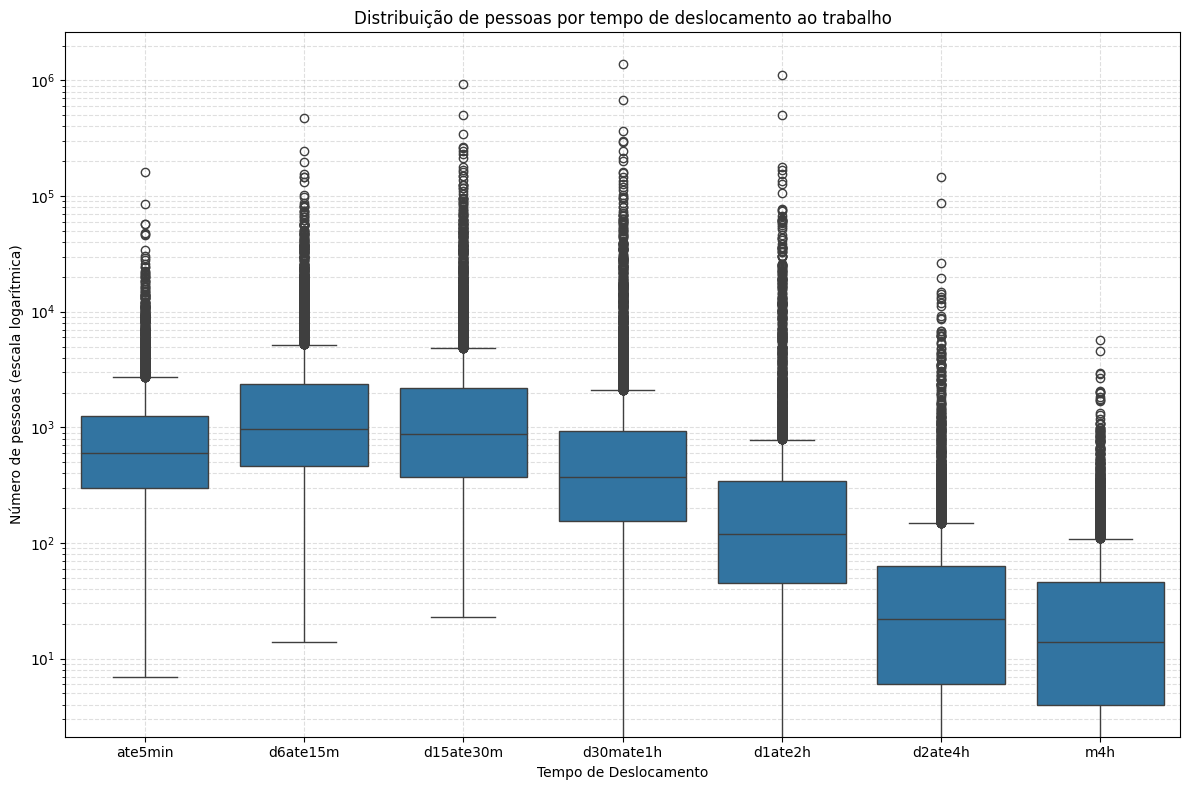

# Fonte: IBGE - Censo Demográfico 2022
# Download de https://sidra.ibge.gov.br/Tabela/10333
Cada ponto representa um município brasileiro em cada boxplot.


In [5]:
# Com boxplot comparar as distribuições de quantidade de pessoas por tempo de deslocamento ao trabalho
# cada categoria de tempo (até 5 min, 6-15 min, 15-30 min, 30m-1h, etc.) em uma coluna de boxplot

# Script para gerar boxplot das distribuições de quantidade de pessoas por tempo de deslocamento ao trabalho

import clickhouse_connect
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Configurar conexão com ClickHouse (ajuste host, username, password conforme seu ambiente)
client = clickhouse_connect.get_client(host='localhost', username='default', password='785498', database='ibge')
# Query SQL
query = """
SELECT
    ct.ate5min,
    ct.d6ate15m,
    ct.d15ate30m,
    ct.d30mate1h,
    ct.d1ate2h,
    ct.d2ate4h,
    ct.m4h
FROM ibge.casatrabalho10333 ct
"""
# Lê diretamente para DataFrame (muito mais rápido)
df = client.query_df(query)
print(df.head())
# Transformar o DataFrame para formato longo
df_melted = df.melt(var_name='Tempo de Deslocamento', value_name='Número de Pessoas')
# Plot boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='Tempo de Deslocamento', y='Número de Pessoas', data=df_melted)
plt.yscale('log')  # opcional: melhora visualização
plt.ylabel('Número de pessoas (escala logarítmica)')
plt.title('Distribuição de pessoas por tempo de deslocamento ao trabalho')
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.tight_layout()
plt.show()
print("# Fonte: IBGE - Censo Demográfico 2022")
print("# Download de https://sidra.ibge.gov.br/Tabela/10333")
print("Cada ponto representa um município brasileiro em cada boxplot.")

In [3]:
# Quais são os outliers em cada categoria?
outliers = {}
for column in df.columns:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column].tolist()

print("Outliers por categoria de tempo de deslocamento:")
for category, values in outliers.items():
    print(f"{category}: {values}")


Outliers por categoria de tempo de deslocamento:
ate5min: [4868, 5635, 2901, 5512, 13093, 3793, 4316, 4375, 10912, 4210, 4474, 4292, 30348, 3554, 4024, 5507, 13465, 5306, 5594, 8058, 4284, 25786, 5470, 5480, 4994, 3632, 3377, 6628, 4798, 8241, 2729, 4964, 6569, 4671, 9506, 2765, 3135, 4302, 3038, 13656, 4562, 6416, 5194, 3171, 3570, 16255, 4152, 4967, 4734, 3837, 6343, 3251, 4030, 3380, 8811, 2963, 3433, 4281, 2901, 4294, 22283, 4298, 3265, 6404, 4395, 3058, 2755, 22170, 3575, 4439, 3055, 3184, 3737, 8063, 4195, 3862, 57148, 3162, 2960, 4806, 4751, 9305, 3584, 6045, 3448, 3706, 4350, 4242, 3065, 3061, 7570, 3267, 3934, 4369, 3142, 6479, 10031, 19800, 2938, 13870, 3078, 21193, 5207, 3075, 3226, 3322, 2887, 11843, 4409, 2776, 2797, 9209, 5396, 5051, 12988, 28194, 4369, 4216, 2745, 3669, 7745, 20163, 13988, 6135, 4604, 3026, 2933, 3463, 6348, 2837, 6455, 3260, 4376, 11778, 3900, 4641, 3456, 2984, 5693, 2928, 2866, 2997, 5113, 7246, 4146, 5276, 4149, 6915, 2882, 34322, 3727, 3218, 5781, 27

# Carregar tabela 5881 - Pessoas de 10 anos ou mais de idade, ocupadas na semana de referência, que, no trabalho principal, trabalhavam fora do domicílio, por tempo habitual de deslocamento do domicílio para o trabalho principal, posição na ocupação, grupo de idade e cor ou raça - Total Brasil
# https://sidra.ibge.gov.br/Tabela/5881
# Variável - Pessoal ocupado na administração direta (Unidades)		
# Vínculo empregatício - Total		
# Ano - 2023		

Converte para UTF8

iconv -f iso-8859-1 -t utf8 tabela5881.csv > tabela5881utf8.csv

Criar tabela no DB
```sql
Use ibge;
CREATE TABLE IF NOT EXISTS pessoas_ocupadas5881
(
    codigo String,
    municipio String,
    pessoas_ocupadas UInt32
)
ENGINE = MergeTree()
ORDER BY codigo;
```

O arquivo do IBGE possui "-" no lugar de valores nulos. Para carregar no banco de dados precisamos substituir os "-" por "0" (zero), mas apenas quando o traço for precedido de ";".

```bash
sed 's/;-/;0/g' tabela5881utf8.csv > tabela5881utf8v2.csv
```

### Remover o cabeçalho e importar

```bash
clickhouse-client --query="INSERT INTO ibge.pessoas_ocupadas5881 FORMAT CSV" --format_csv_delimiter=";" --input_format_skip_unknown_fields=1 < <(tail -n +2 tabela5881utf8v2.csv)
```


                     municipio   m4h  pessoas_ocupadas  proporcao_m4h
0   Serranópolis de Minas (MG)   232              1141       0.203330
1                  Chaves (PA)   640              3422       0.187025
2                  Lastro (PB)    52               316       0.164557
3         Tenente Ananias (RN)   282              1817       0.155201
4     Riacho dos Machados (MG)   351              2716       0.129234
..                         ...   ...               ...            ...
95  São João do Jaguaribe (CE)    69              1434       0.048117
96          Santa Brígida (BA)   159              3324       0.047834
97            Major Sales (RN)    44               922       0.047722
98               Itaituba (PA)  1828             38311       0.047715
99             Itacarambi (MG)   235              4949       0.047484

[100 rows x 4 columns]


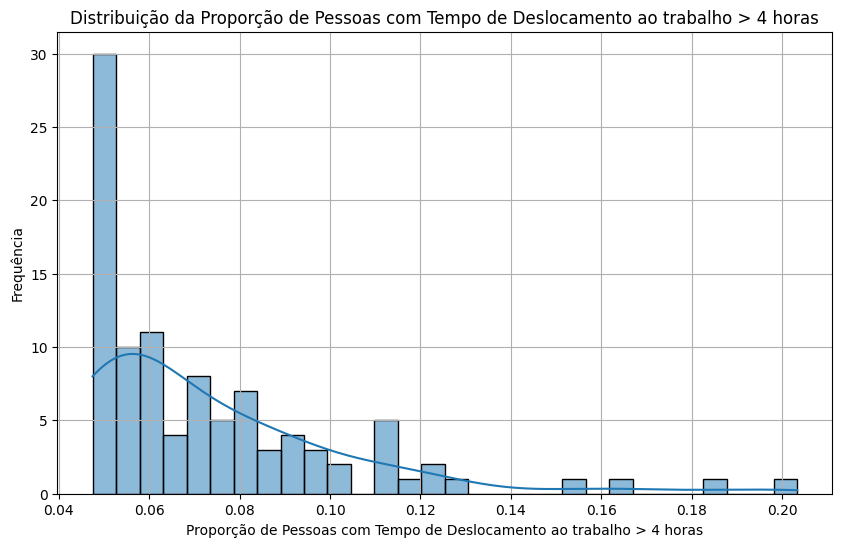

In [ ]:
# Quais são os top 100 municípios com pior tempo de deslocamento na faixa m4h?
# Considerando a quantidade de pessoas proporcionais ao total de pessoas que trabalham no município

import clickhouse_connect
import pandas as pd

# Configurar conexão com ClickHouse (ajuste host, username, password conforme seu ambiente)
client = clickhouse_connect.get_client(host='localhost', username='default', password='785498', database='ibge')

# Query SQL
query = """
SELECT
    ct.municipio,
    ct.m4h,
    po.pessoas_ocupadas,
    (ct.m4h / po.pessoas_ocupadas) AS proporcao_m4h
FROM ibge.casatrabalho10333 ct inner JOIN ibge.pessoas_ocupadas5881 po
ON ct.codigo = po.codigo
ORDER BY proporcao_m4h DESC
LIMIT 100
"""

# Pode usar o somatório de todos os tempos = pessoas ocupadas se preferir
# faz mais sentido para o cálculo da proporção
query = """
SELECT
    ct.municipio,
    ct.m4h,
    ct.ate5min + ct.d6ate15m + ct.d15ate30m + ct.d30mate1h + ct.d1ate2h + ct.d2ate4h + ct.m4h AS pessoas_ocupadas,
    (ct.m4h / (ct.ate5min + ct.d6ate15m + ct.d15ate30m + ct.d30mate1h + ct.d1ate2h + ct.d2ate4h + ct.m4h)) AS proporcao_m4h
FROM ibge.casatrabalho10333 ct 
ORDER BY proporcao_m4h DESC
LIMIT 100
"""

# Lê diretamente para DataFrame (muito mais rápido)
df = client.query_df(query)
print(df)

# Visualizar a distribuição da proporção de pessoas com tempo de deslocamento maior que 4 horas
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(df['proporcao_m4h'], bins=30, kde=True)
plt.title('Distribuição da Proporção de Pessoas com Tempo de Deslocamento ao trabalho > 4 horas')
plt.xlabel('Proporção de Pessoas com Tempo de Deslocamento ao trabalho > 4 horas')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()  